In this notebook, I will use the best of both the worlds:

- Use `tsfresh` to extract features
- Use `Dask` for parallelization and handling larger than memory dataset
    - Dask will distribute the jobs across multiple cores (single machine or distributed cluster)
    - Dask DataFrame utlizes out of core computing
    
This notebook is divided into two sections
- Dask Basics
- Automated FE using `tsfresh` & `Dask`

In [2]:
import glob
import os
import sys

import pandas as pd
import numpy as np

import dask
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd

In [3]:
def get_segment_id_from_path(df, path):
    """
    Returns the segment_id from the path of the file 
    """
    df.segment_id = df.segment_id.str.replace(path, "", regex=False)
    df.segment_id = df.segment_id.str.replace(".csv", "", regex=False)
    df.segment_id = df.segment_id.astype(np.int64)
    
    return df

def append_time_column(df):
    df["time"] = range(0, len(df))
    
    return df

# Path for raw data
DATA_DIR = "/datadrive/arnab/vssexclude/kaggle/volcano/data/train"
# Path to save generated features
FEATURE_PATH = "/datadrive/arnab/vssexclude/kaggle/volcano/data/features"

# Define the datatypes for different sensor data
data_types = {"sensor_1" : np.float32, 
                 "sensor_2" : np.float32, 
                 "sensor_3" : np.float32,
                 "sensor_4" : np.float32,
                 "sensor_5" : np.float32,
                 "sensor_6" : np.float32,
                 "sensor_7" : np.float32,
                 "sensor_8" : np.float32,
                 "sensor_9" : np.float32,
                 "sensor_10" : np.float32}

# Dask Basics

### Dask Architechture

Technically, Dask is a centrally managed distributed service with distributed storage and execution with the workers and peer to peer communication. 

<img src="../images/dask_architechture_diagram.png" width="600" height="200" style="border-style: solid;">

#### What is a Client?

The Client connects users to a Dask cluster. After a Dask cluster is setup, we initialize a Client by pointing it to the address of a Scheduler:

```python
from distributed import Client
client = Client("1.2.3.4:8786")
```



Here we are creating a Local Cluster and then connecting the Dask Client to the Local Cluster. 

By specifying `n_worker=10`, we have asked to dask to start `10` independent python processes. Based on the nature of the cluster, they may run in the same machine or different machines.

In [3]:
cluster = LocalCluster(n_workers=8, 
                       threads_per_worker=1, 
                       scheduler_port=8786, 
                       memory_limit='2GB')

client = Client(cluster)

client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 16.00 GB


### Read Data

In [4]:
!ls -lrt {DATA_DIR}/1408*.csv | wc -l

4


In [5]:
%%time
ddf = dd.read_csv(
    urlpath=f"{DATA_DIR}/1408*.csv", 
    blocksize=None, 
    dtype=data_types,
    include_path_column='segment_id')

CPU times: user 111 ms, sys: 25 ms, total: 136 ms
Wall time: 140 ms


#### What just happened:
- Dask just checked the input path and found that there are multiple CSV files matching the path description
- It has not really loaded the content of the individual CSV files yet. 
- Nothing happens in the Dask UI, because these operations are just setting up a task graph which will be executed later
- Dask is lazy by default. It will load all the CSV files into the memory **in parallel** only when we ask for any result
- We can ask for result by invoking `compute()` method

Note:
- None value for `blocksize` creates single partition for each CSV file

In [6]:
ddf

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,segment_id
npartitions=4,,,,,,,,,,,
,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,category[known]
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


### What is Dask DataFrame?

- Dask DataFrame API extends Pandas to work on **larger than memory** datasets on laptops or distributed datasets across the clusters
- It reuses lot of Pandas' code and extends the scale.

### How Dask DataFrame is constructed?

<img src="../images/pandas_vs_dask_DF.png" width="400" height="200" style="border-style: solid;">

#### Observations
- This Dask DataFrame is composed of 4 Pandas DataFrame
- It has the column names and data types
- It has 4 tasks, i.e. 4 small Python functions which must be run to execute this entire Dask DataFrame.

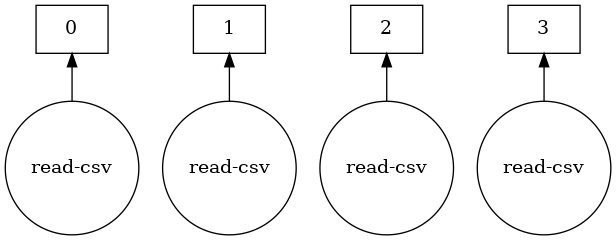

In [7]:
ddf.visualize()

#### Let's compute the maximum value of the `sensor_1` feature

In [8]:
ddf.sensor_1.max()

dd.Scalar<series-..., dtype=float32>

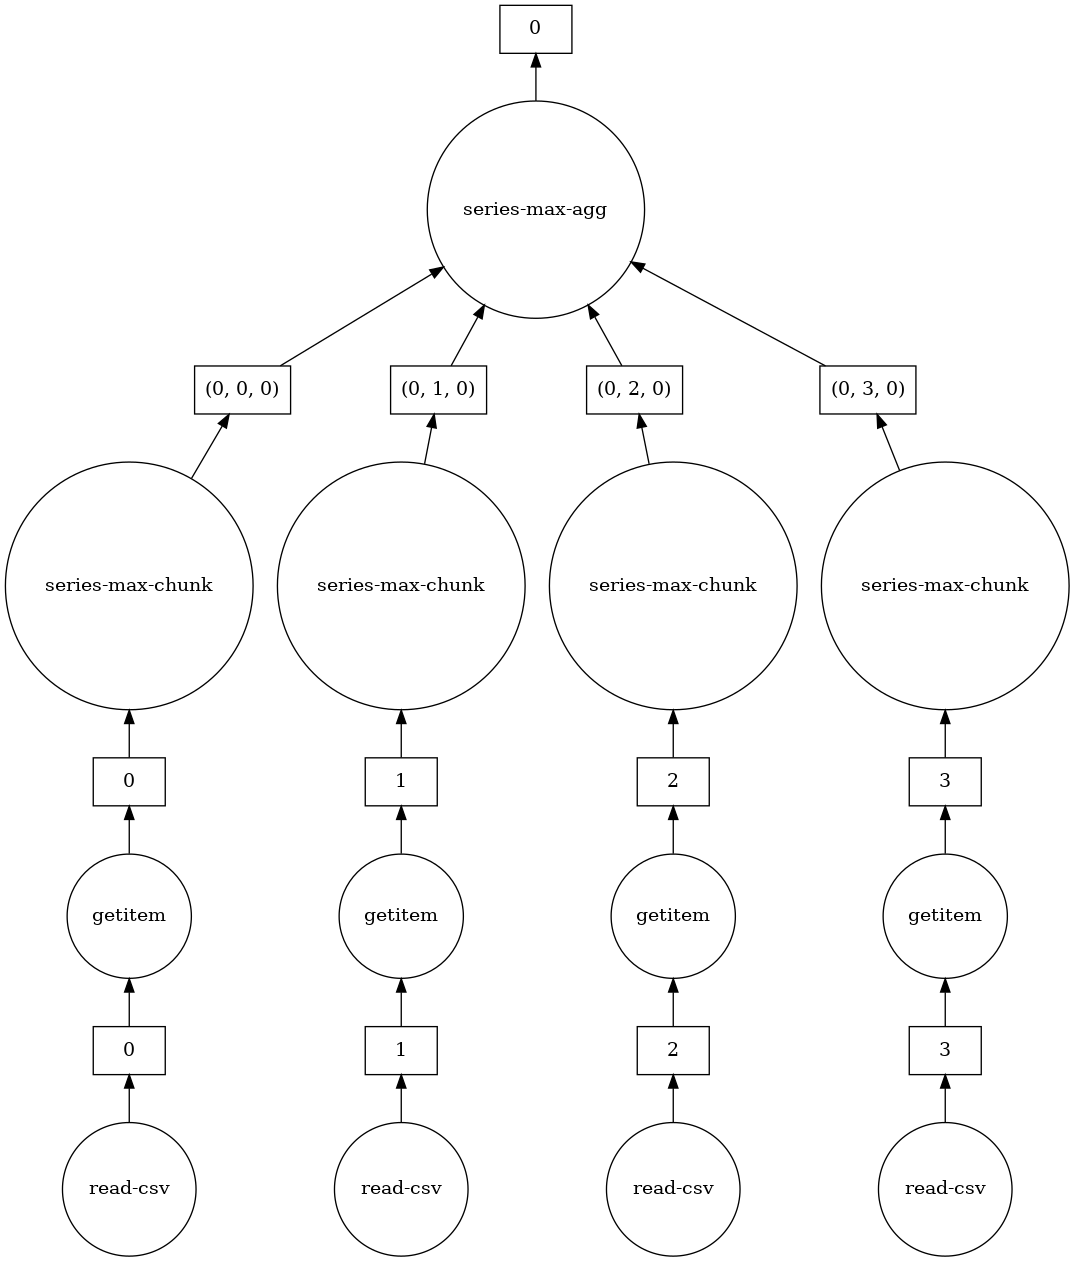

In [9]:
ddf.sensor_1.max().visualize()

In [10]:
ddf.sensor_1.max().compute()

7427.0

In [11]:
type(ddf.sensor_1.max().compute())

numpy.float64

#### What just happened?
- Dask checked the input path. Identified the matching files
- A bunch of jobs were created. Here, one job per chunk/partition. 
- Each CSV file is read from the memory and loaded into a Pandas Dataframe
- For each Pandas DataFrame, maximum value of `sensor_1` feature is computed
- Results from multiple Pandas DataFrame are combined to get the final result, i.e., the maximum value of `sensor_1` across all the CSVs
- Look at the Dask Dashboard before and after the compute()


- Note: **The result of `compute()` must fit in-memory.**


## How to parallelize a custom function working on individual partitions?

#### Problem Statement

- I have a function which works well on one Pandas DataFrame. How can I parallelize it over multiple Pandas DataFrame?

`map_partitions()` is the answer. It applies the function in an **embarrassingly parallel** way to multiple Pandas DataFrame 

#### Calculate the percentage of missing values across sensors for all the segments

In [12]:
def get_missing_sensors(df):
    """
    Returns a DataFrame consisting percentage of missing data per sensor
    """
    df_missing_percentage = df.isna().mean().to_frame().transpose()
    df_missing_percentage = df_missing_percentage.astype(np.float16)
    return df_missing_percentage

In [13]:
df_train_seg_missing = ddf.map_partitions(get_missing_sensors).compute()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,segment_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01017,0.0,0.0
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,0.0,0.0
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


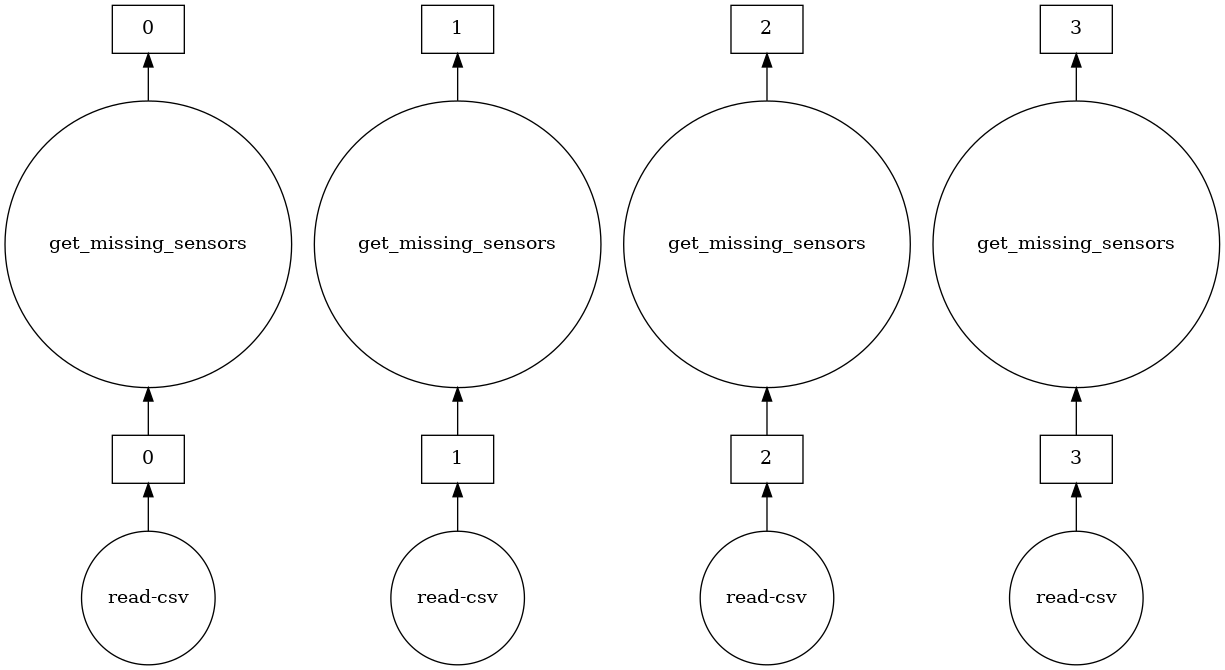

In [14]:
ddf.map_partitions(get_missing_sensors).visualize()

In [15]:
client.close()
cluster.close()

# Automated FE using `tsfresh` & `Dask`

Here, input data starts from the hard drive & output (extracted features) will end on the hard drive. 

In between, Dask will read input data chunk by chunk, extract features and write to hard drive.

### Steps

- Create a Dask Cluster and connect a Client to it.
- Read data using Dask DataFrame from hard drive.
- Extract features using `tsfresh.feature_extraction.extract_features`. Dask parallelizes execution of this function using `map_partitions`.
- Write the extracted features to hard drive segment by segment.

### 1. Create a Dask Cluster and connect a Client to it

In [4]:
cluster = LocalCluster(n_workers=8, 
                       threads_per_worker=1, 
                       scheduler_port=8786, 
                       memory_limit='3GB')

client = Client(cluster)

client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 24.00 GB


### 2. Read Data using Dask DataFrame

In [5]:
ddf = dd.read_csv(
    urlpath=f"{DATA_DIR}/1*.csv", 
    blocksize=None, 
    usecols=["sensor_1", "sensor_4"],
    dtype=data_types,
    include_path_column='segment_id')

# Use the first 1000 observations
ddf = ddf.loc[0:999, :]

# Insert a new column with segment_id along with the values from 10 sensors
ddf = ddf.map_partitions(get_segment_id_from_path, f"{DATA_DIR}/")

# Add a column named time with ascending values staring from 0 representing time
ddf = ddf.map_partitions(append_time_column)

ddf = ddf.fillna(0)

### 3. Generate Features for individual partitions in parallel using Dask

Here I am going to parallize the function `tsfresh.feature_extraction.extract_features()` using 

In [7]:
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction.settings import MinimalFCParameters

def custom_extract_features(df, column_id, column_sort, default_fc_parameters):
    """
    Generate features using `extract_features` of `tsfresh` and then rename and 
    reset axis.
    
    Setting `n_jobs` to 0 disable multiprocessing functionality
    """
    feature_df = extract_features(df, 
                                  column_id=column_id, 
                                  column_sort=column_sort, 
                                  n_jobs=0, 
                                  default_fc_parameters=default_fc_parameters,
                                  disable_progressbar=True)
    feature_df = feature_df.rename_axis("segment_id").reset_index(drop=False)
    feature_df.segment_id = feature_df.segment_id.astype('category')
    return feature_df

In [8]:
my_fc = {
    'maximum': None,
    'minimum': None
}

ddf_features = ddf.map_partitions(custom_extract_features, 
                                  column_id='segment_id',
                                  column_sort='time',
                                  default_fc_parameters=my_fc)

In [9]:
ddf_features

,segment_id,sensor_1__maximum,sensor_1__minimum,sensor_4__maximum,sensor_4__minimum
npartitions=2306,,,,,
,category[known],float64,float64,float64,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


### 4. Write extracted features back to hard drive

In [10]:
ddf_features.to_parquet(
    path=f"{FEATURE_PATH}", 
    write_index=False, 
    partition_on="segment_id",
    engine="pyarrow",
    append=False)

### 5. Read generated features for verification

Read using Pandas

In [11]:
SEGMENT_ID = "1999605295"
df = pd.read_parquet(f"{FEATURE_PATH}/segment_id={SEGMENT_ID}")

df.head()

,sensor_1__maximum,sensor_1__minimum,sensor_4__maximum,sensor_4__minimum
0,725.0,-866.0,895.0,-954.0


Read using Dask

In [12]:
ddf_features_from_disk = dd.read_parquet(path=f"{FEATURE_PATH}/*/*.parquet")

In [13]:
ddf_features_from_disk

,sensor_1__maximum,sensor_1__minimum,sensor_4__maximum,sensor_4__minimum
npartitions=2306,,,,
,float64,float64,float64,float64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [14]:
ddf_features_from_disk.partitions[3].compute()

,sensor_1__maximum,sensor_1__minimum,sensor_4__maximum,sensor_4__minimum
0,407.0,-531.0,516.0,-625.0


In [15]:
client.close()
cluster.close()